## Only using tensorflow to import a dataset

In [181]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

/tmp/ipykernel_35877/2840488367.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


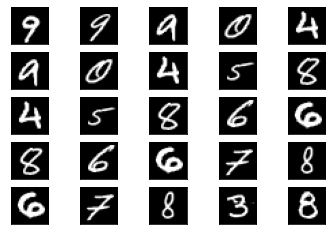

In [182]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

## Code

## Import

In [183]:
import numpy as np

## flatten and reshape

In [184]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T # flatten
print("x_train flatten:", x_train.shape)

print("x_test:", x_test.shape)
x_test = x_test.reshape(x_test.shape[0], -1).T # flatten
print("x_test flatten:", x_test.shape)

print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T # reshape
print("y_train:", y_train.shape)

print("y_test:", y_test.shape)
y_test = y_test.reshape(y_test.shape[0],1).T # reshape
print("y_test:", y_test.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
x_test: (10000, 28, 28)
x_test flatten: (784, 10000)
y_train: (60000,)
y_train: (1, 60000)
y_test: (10000,)
y_test: (1, 10000)


## One Hot

In [185]:
def one_hot_encoder(y):
    y_onehot = np.zeros((len(np.unique(y)), y.shape[1]))
    
    for i in range(y_onehot.shape[1]):
        y_onehot[y[0][i]][i] = 1
        
    return y_onehot

In [186]:
y_train_onehot = one_hot_encoder(y_train)
y_test_onehot = one_hot_encoder(y_test)

print(y_train_onehot)
print(y_test_onehot)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Normalization

In [187]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [200]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters[f'W{l}'] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters[f'b{l}'] = np.ones((layers_dims[l], 1), dtype=np.float32)
    
    return parameters

## activation_funtion

In [201]:
def activation_funtion(Z, activation):
    if activation == "relu":
        return np.maximum(np.zeros_like(Z), Z)
        
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-Z))  # 1 / (1+e^-Z)
        
    
    return Z

def activation_derivative(Z, activation):
    if activation == "relu":
        dZ = np.ones(Z.shape)
        return (dZ >= 0).astype(int)
        
    if activation == "sigmoid":
        sig = activation_funtion(Z, "sigmoid")
        return sig * (1 - sig)  # sigmoid * (1 - sigmoid)
    
    return Z

## forward_propagation

In [202]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters) // 2
    cache["A0"] = X
    l = 0
    
    for l in range(1,L):
        cache[f"Z{l}"] = np.dot(parameters[f"W{l}"], cache[f"A{l-1}"]) + parameters[f"b{l}"]
        cache[f"A{l}"] = activation_funtion(cache[f"Z{l}"], activation[l-1])

    l += 1
    
    cache[f"Z{l}"] = np.dot(parameters[f"W{l}"], cache[f"A{l-1}"]) + parameters[f"b{l}"]
    cache[f"A{l}"] = activation_funtion(cache[f"Z{l}"], activation[l-1])
    cache["output"] = cache[f"A{l}"]
    return cache

## compute_cost

In [203]:
def compute_cost(AL, Y, loss="cross_entropy"):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-8
        cost = - (1/m) * np.sum((np.log(AL + epsilon) * Y) + (np.log(1 - AL + epsilon) * (1 - Y)))
        return np.squeeze(cost).astype(np.float32)

    return np.mean(np.abs(AL - Y)) * 100

def compute_acc(AL, Y):
    return 100 - np.mean(np.abs(AL - Y)) * 100

## back_propagation

In [204]:
def back_propagation(X, Y, parameters, cache, activation):
    grads = {}
    L = len(parameters) // 2
    div_shape = (1 / Y.shape[1])
    
    grads[f"dZ{L}"] = cache[f"A{L}"] - Y
    grads[f"dW{L}"] = div_shape * np.dot(grads[f"dZ{L}"], cache[f"A{L-1}"].T)
    grads[f"db{L}"] = div_shape * np.sum(grads[f"dZ{L}"], axis= 1, keepdims= True)
    
    for l in range(L-1,0,-1):
        grads[f"dZ{l}"] = np.dot(parameters[f"W{l+1}"].T, grads[f"dZ{l+1}"]) * activation_derivative(cache[f"Z{l}"], activation[l-1])
        grads[f"dW{l}"] = div_shape * np.dot(grads[f"dZ{l}"], cache[f"A{l-1}"].T)
        grads[f"db{l}"] = div_shape * np.sum(grads[f"dZ{l}"], axis= 1, keepdims= True)
    
    return grads

## update_parameters

In [205]:
def update_parameters(grads, parameters, lr=0.01):
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters[f"W{l}"] = parameters[f"W{l}"] - (grads[f"dW{l}"] * lr)
        parameters[f"b{l}"] = parameters[f"b{l}"] - (grads[f"db{l}"] * lr)
    
    return parameters

In [285]:
def cost_acc(Y, cache_calc, type="train"):
    cost = compute_cost(cache_calc.T, Y, loss="cross_entropy")
    acc = compute_acc(cache_calc, Y)

    if type == "test":
        print(" | ", end="")

    print(f"cost_{type}: {cost:.2f}", end= " ")
    print(f"acc_{type}: {acc:.2f}", end= "")

In [286]:
def run(X_train=None, Y_train=None, X_test=None, Y_test=None, layers_dims=None, activation=None, lr=0.001, iter=100):
    parameters = initialize_parameters(layers_dims)
    
    for i in range(iter):
        cache = forward_propagation(X_train, parameters, activation)
    
        if i % 10 == 0:
            cost_acc(Y_train, cache[f"A{len(parameters) // 2}"], type="train")
            
            if X_test is not None and Y_test is not None:
                cache_test = forward_propagation(X_test, parameters, activation)
                cost_acc(Y_test, cache_test[f"A{len(parameters) // 2}"], type="test")
            print()
            
        grads = back_propagation(X_train, Y_train, parameters, cache, activation)
        parameters = update_parameters(grads, parameters, lr)
    
    return parameters

In [287]:
layers_dims1 = [x_train.shape[0],64,64,64,64,10]
activation1 = ["relu","relu","relu","relu","sigmoid"]
# loss_funtion = "cross_entropy"

print(x_train.shape)
print(y_train.shape)

parameters = run(X_train=x_train, Y_train=y_train_onehot, X_test=x_test, Y_test=y_test_onehot, layers_dims=layers_dims1, activation=activation1, lr=0.01, iter=500)

(784, 60000)
(1, 60000)
cost_train: 25.94 acc_train: 29.62 | cost_test: 25.88 acc_test: 29.59
cost_train: 3.13 acc_train: 82.47 | cost_test: 3.12 acc_test: 82.49
cost_train: 2.87 acc_train: 83.19 | cost_test: 2.85 acc_test: 83.23
cost_train: 2.61 acc_train: 84.12 | cost_test: 2.59 acc_test: 84.19
cost_train: 2.38 acc_train: 85.12 | cost_test: 2.35 acc_test: 85.22
cost_train: 2.19 acc_train: 86.05 | cost_test: 2.17 acc_test: 86.16
cost_train: 2.05 acc_train: 86.86 | cost_test: 2.02 acc_test: 86.97
cost_train: 1.93 acc_train: 87.54 | cost_test: 1.91 acc_test: 87.65
cost_train: 1.84 acc_train: 88.12 | cost_test: 1.81 acc_test: 88.22
cost_train: 1.76 acc_train: 88.62 | cost_test: 1.73 acc_test: 88.72
cost_train: 1.68 acc_train: 89.08 | cost_test: 1.66 acc_test: 89.18
cost_train: 1.61 acc_train: 89.51 | cost_test: 1.59 acc_test: 89.61
cost_train: 1.55 acc_train: 89.92 | cost_test: 1.52 acc_test: 90.01
cost_train: 1.49 acc_train: 90.31 | cost_test: 1.46 acc_test: 90.40
cost_train: 1.43 acc_t

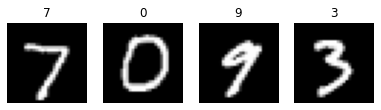

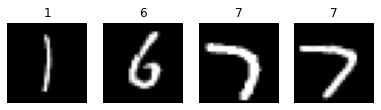

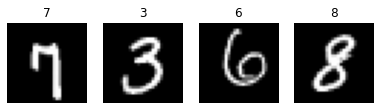

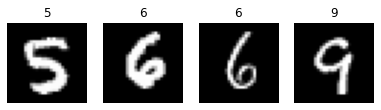

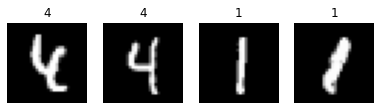

In [289]:
list_pos = [i*10 for i in range(20)]

for i, pos in enumerate(list_pos):
    img = np.reshape(x_test[:,pos], (28,28))
    
    if i % 4 == 0:
        plt.figure(figsize=(34,34))
    plt.subplot(len(list_pos)//4, len(list_pos), i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    x_test_i = img.flatten() # flatten
    x_test_i = np.expand_dims(x_test_i, -1)
    cache = forward_propagation(x_test_i, parameters, activation1)
    
    plt.title(np.argmax(cache['output']))